In [1]:
import keras
import csv
import os
import itertools
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.layers import *
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications.xception import Xception
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
TRAIN_DIR = os.path.join(ROOT_DIR, 'data', 'train')
TEST_DIR =  os.path.join(ROOT_DIR, 'data', 'validation')

In [4]:
img_width, img_height = 300, 300

In [5]:
batch_size = 32
epoch = 5
drop_prob = 0.6
out_class = 13

In [6]:
train_gen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.2, horizontal_flip = True, vertical_flip = True)

In [7]:
test_gen = ImageDataGenerator(rescale=1. / 255)

In [8]:
train_generator = train_gen.flow_from_directory(TRAIN_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 152397 images belonging to 13 classes.


In [9]:
'''val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')'''

"val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), \n                                                batch_size=batch_size, class_mode='categorical')"

In [10]:
test_generator = test_gen.flow_from_directory(TEST_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 55388 images belonging to 13 classes.


In [11]:
input_ = Input(shape=(img_width, img_height, 3))

transfer_model = Xception(input_tensor = input_, weights = 'imagenet', include_top = False)

83689472/83683744 [==============================] - 8s 0us/step


In [12]:
x = transfer_model.output

x = MaxPooling2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)

x = Dropout(drop_prob)(x)

out = Dense(out_class, activation = 'softmax')(x)

In [13]:
model = Model(inputs = transfer_model.input, outputs = out)

In [14]:
adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [15]:
for layer in transfer_model.layers:
    layer.trainable = False

In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_, metrics = ['accuracy'])

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [ ]:
#tensorboard = TensorBoardColabCallback(TensorBoardColab()) #Using Tensorboard on google colab

In [ ]:
checkpointer = ModelCheckpoint(filepath='checkpoint_inception.h5', save_best_only=True)

In [ ]:
callback_list = [checkpointer]

In [19]:
history = model.fit_generator(train_generator, steps_per_epoch = int(152397/batch_size), epochs = epoch, shuffle = True)

Epoch 1/5
4762/4762 [==============================] - 2040s 428ms/step - loss: 0.3933 - acc: 0.8730
Epoch 2/5
4762/4762 [==============================] - 2696s 566ms/step - loss: 0.2900 - acc: 0.9101
Epoch 3/5
4762/4762 [==============================] - 2544s 534ms/step - loss: 0.2785 - acc: 0.9171
Epoch 4/5
4762/4762 [==============================] - 2232s 469ms/step - loss: 0.2732 - acc: 0.9208
Epoch 5/5
4762/4762 [==============================] - 2120s 445ms/step - loss: 0.2780 - acc: 0.9231


In [20]:
Y_pred = model.predict_generator(test_generator, int(55388/batch_size+1))
y_pred = np.argmax(Y_pred, axis=1)

In [21]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, int(55388/batch_size+1))

In [22]:
test_loss

3.7941755311811254

In [23]:
test_accuracy

0.4517585036405426

In [ ]:
model_check = load_model('checkpoint_inception.h5')

In [ ]:
#test_check_loss, test_check_acc = model_check.evaluate_generator(test_generator, int(795/batch_size+1))

In [ ]:
test_check_loss

In [ ]:
test_check_acc

In [24]:
target_names = ['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 
                'skateboard', 'train', 'truck']

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()

In [26]:
cnf = confusion_matrix(test_generator.classes, y_pred)

Confusion matrix
[[ 223   82  234  431  136  393  568    9  117  117 1237   99]
 [ 181   83  216  387  126  388  543   12  113  106 1242   78]
 [ 281  112  329  524  157  533  779   14  171  119 1578   93]
 [ 604  214  661 1193  313 1147 1772   34  341  320 3564  238]
 [ 263  103  306  572  162  452  763   10  174  170 1612  104]
 [ 120   37  119  253   68  223  304    7   77   57  754   56]
 [ 315  132  366  606  205  637  983   14  205  180 1999  154]
 [ 266   89  278  457  126  412  635   15  149  130 1353   90]
 [ 244  101  289  529  157  479  764   11  145  121 1576  133]
 [ 133   52  137  268   81  256  383    6   70   57  780   58]
 [ 231   98  274  472  138  444  710   14  140  107 1506  102]
 [ 349  125  319  613  199  550  920   18  185  163 1980  127]]


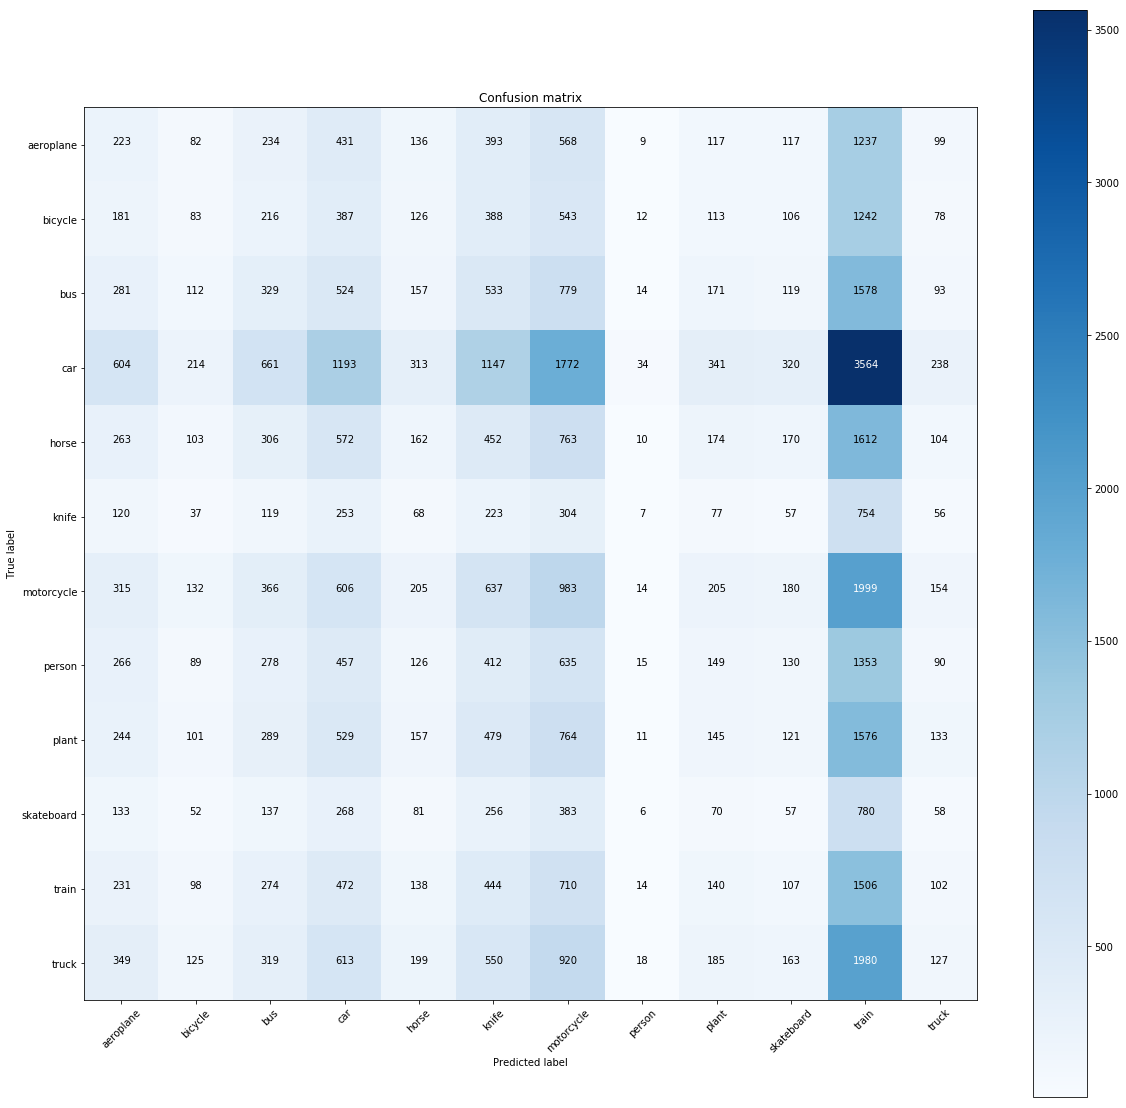

In [27]:
plot_confusion_matrix(cnf, classes=target_names, title='Confusion matrix')

In [28]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   aeroplane       0.07      0.06      0.07      3646
     bicycle       0.07      0.02      0.04      3475
         bus       0.09      0.07      0.08      4690
         car       0.19      0.11      0.14     10401
       horse       0.09      0.03      0.05      4691
       knife       0.04      0.11      0.06      2075
  motorcycle       0.11      0.17      0.13      5796
      person       0.09      0.00      0.01      4000
       plant       0.08      0.03      0.05      4549
  skateboard       0.03      0.02      0.03      2281
       train       0.08      0.36      0.13      4236
       truck       0.10      0.02      0.04      5548

   micro avg       0.09      0.09      0.09     55388
   macro avg       0.09      0.09      0.07     55388
weighted avg       0.10      0.09      0.08     55388



In [29]:
model.save('xception.h5')